# Energy Consumption Forecasting with Transformers

A workflow for forecasting household energy consumption using a Transformer-based model is presented. The process includes data acquisition, preprocessing, modeling, evaluation, and discussion of results.

## Table of Contents
1. Download dataset
2. Preprocessing
3. Modeling
4. Evaluation
5. Discussion

## 1. Download dataset

The dataset is downloaded from the UCI Machine Learning Repository using a dedicated Python module. The file is stored locally if it does not already exist.

In [ ]:
# from energy_forecast_transformer.download import download_kaggle_dataset
# download_kaggle_dataset('uciml/electric-power-consumption-data-set', './data')

In [1]:
from src.preprocessing import load_and_clean_data

df = load_and_clean_data('./data/household_power_consumption.txt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [2]:
from summarytools import dfSummary # for summary of the data
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Global_active_power[float64],Mean (sd) : 1.1 (1.1)min < med < max:0.1 < 0.6 < 11.1IQR (CV) : 1.2 (1.0),"4,186 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8ekN5oAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB90lEQVR4nO3cy2rCQACF4Zl6IVUaEUF3PkIXLn2IPmy33fssIogXTLWRMGWELkvNxGjO9P/WJor8xCh4rHPOAE339OgXAFyj/dcDrLXPxpiuCZM7546BxwLXheojHY1Gb2maDk2A/X6/sda+EyvqvqJ2faTz+fw4GAxOZU682+2SxWIxXK/X/mpMqKj3o9/zkY7H48+A8/vbBqAyvkxBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqEinjW/UEVRdIwxqbU29BQMAaPeULMs65zP59fpdNpqtVqltlV/MASM2kPN87ydJElvNpudJpPJpuzxDAHjbh/9Xr/fDx0B9hgCxgVfpiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGh9r9LP3BphZWViDQ21KpLK6ysxKWxoVZZWmFlJT6NDfUGSyusrESk8aGGYkkwLlGGypJgfKIMlSXB+EQZ6i2WBIuiSPlpTCxUf4Upe+LD4XA5JsuyZLVa9e55fNXnXi6XL1VuHbbb7cFa+2GMCbrt+Ke+nHO/vl/fGu/Rh1pBmqsAAAAASUVORK5CYII="">","25,979(1.3%)"
2,Global_reactive_power[float64],Mean (sd) : 0.1 (0.1)min < med < max:0.0 < 0.1 < 1.4IQR (CV) : 0.1 (1.1),532 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8ekN5oAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB6ElEQVR4nO3dQWrCQBiG4ZlGJVUaEUF3HqELlx6ih+22e88igmgkURuRKSN0WWomjeZL32ftDCIviQF/xzrnDNB0T49+A8AtOr+9wFr7bIzpmTCFc+4YuBa4LVQf6Xg8fkuSZGQC7Pf7rbX2nVhR9xW15yNdLBbH4XB4KrNxmqbxcrkcbTYbfzUmVNR76/d8pJPJ5BCwv//aAFTGwxQkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECracypKqMvl0jXGJNba0C04UA31hprnefd8Pr/OZrMoiqJSZ1R940A11B5qURSdOI778/n8NJ1Ot2XXc6Aa7nbr9waDQehhah4HquGKhylIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIqP33qA8cZWGMpUUaG2rVURbGWNqlsaFWGWVhjKV9GhvqH4yyMMbSIjxMQQKhQkLjb/2h+POLfxiqfzgpu3GWZdc1eZ7H6/W6f8/1q9XqpeqfX+x2u8xa+2GMCVoPU9anc+7Hz/oLtvGf8iACDFcAAAAASUVORK5CYII="">","25,979(1.3%)"
3,Voltage[float64],Mean (sd) : 240.8 (3.2)min < med < max:223.2 < 241.0 < 254.2IQR (CV) : 3.9 (74.3),"2,837 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8ekN5oAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAClUlEQVR4nO3du24aQRiG4Zngw3IQBhFDR0sRiYKSi8jF5hJS0NLQUtEhDloEAS8sG62UIrEUxXvAnm/yPrXHrOwXxIr5GZskiQFc9+mjLwB4i7s3/RQysdZWjTEPOZdHSZIcS74keYR6g0g7nc7XZrPZzrN+t9ttrbXfiPVPhFq+hzTS8Xh8fHp6OmVZGIZhMJlM2uv1On01JtTfEOqNpJF2u90fOZambxvwCjdTkECokECokECokECokECokECokECokECokECokECokMBn/Y6J4/jeGNO01ub9FZGPO68I1SGHw+H+fD4P+/1+pVKpZNp55fs2QUJ1SBRFd0EQ1Eaj0anX622zrg893iZIqA6q1+t5twh6u02QmylIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIYLiv/CN4mtfrNZ3NR4kIteQjeM7ncxDH8ZfT6fTdGJN3khSvEGrJR/AsFov2bDarXS6Xyu0u7/9DqCUfwbPdbr2cq/9o3ExBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAh+heiYudqqKsyeqEKpHDgVPVXH5RBVC9UhU4FQV109UIVQP1fOfquLszi9upiDB21fUAqMkKcZJHONlqEVGSVKMk7jHy1CLjJKkGCdxj6+h5h4lSTFO4h5upiCBUCGBUCHB6feofFuJ1D6Bm+4VcDZUvq1Ea5/ArfcK/DNUa21gjHk076/ZaDSeh8PhpVqtvmRZuFqtgvl8XgvDsL5cLqOsD7zf74Nf/7xguVzWFNaagus3m00j3ScwGAxsq9XK9PdOHY/Hx+l0+rxerz9ba3dZ1xtjXpIk+esT5Cf3WBseq5MA1AAAAABJRU5ErkJggg=="">","25,979(1.3%)"
4,Global_intensity[float64],Mean (sd) : 4.6 (4.4)min < med < max:0.2 < 2.6 < 48.4IQR (CV) : 5.0 (1.0),221 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8ekN5oAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB/UlEQVR4nO3cQWrCQACF4ZlGS6qgiEV3HqELlx6ih+22S8HDCEENprERmTKCy1IdjeZN/29tgrQ/o1n4rHPOAE339Og3AJyj9dcLrLUvxphnE6ZyzpWB1wLnheojHQ6H771eb2AC5Hm+stZ+ECvqPlGffaSz2azs9/u7S2682WzSxWIxyLLMn8aEino/+j0f6Wg0+gq4v//aAFyNhylIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRI

## 2. Preprocessing

In this section, we clean the data, handle missing values, resample the time series, and normalize the features.

### 2.1 Fill in missing values

Filling missing values is crucial for time series forecasting. Here, we use linear interpolation to estimate and fill missing data points, ensuring continuity and reducing the risk of bias in the model.

In [3]:
from src.preprocessing import fill_missing_values

df = fill_missing_values(df)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### 2.2 Resample dataset

Resampling the dataset allows to aggregate the data to a different time frequency (e.g., daily). This can help reduce noise and align the data with the requirements of the forecasting model.

In [4]:
from src.preprocessing import resample_data

df_daily = resample_data(df, freq='D')
df_daily.shape

(1442, 7)

In [5]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


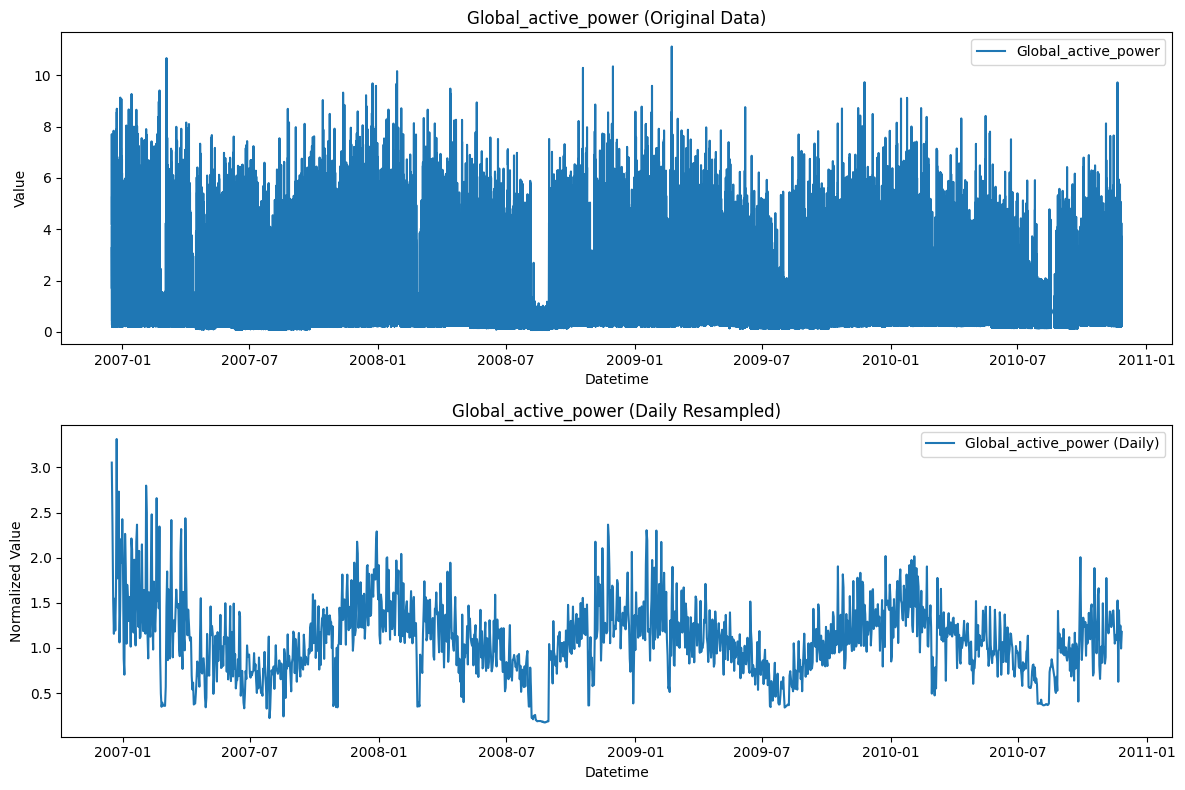

In [6]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
tags = df.columns.tolist()
tag = tags[0]

# Plot for df (original, minute-level)
axs[0].plot(df.index, df[tag], label=tag)
axs[0].set_title(f'{tag} (Original Data)')
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Value')
axs[0].legend()

# Plot for df_daily (resampled, daily)
axs[1].plot(df_daily.index, df_daily[tag], label=f'{tag} (Daily)')
axs[1].set_title(f'{tag} (Daily Resampled)')
axs[1].set_xlabel('Datetime')
axs[1].set_ylabel('Normalized Value')
axs[1].legend()

plt.tight_layout()
plt.show()

### 2.3 Normalization

Normalization scales all features to a common range, typically [0, 1]. This step is important, as it helps the model converge faster and prevents features with larger scales from dominating the learning process.

In [7]:
from src.preprocessing import normalize_data

columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df_daily, scaler = normalize_data(df_daily, columns=columns)

In [8]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,0.916786,0.260147,0.315385,0.928499,0.000000,0.163965,0.754442
2006-12-17,0.694252,0.512027,0.550494,0.695226,0.181130,0.345776,0.561892
2006-12-18,0.431901,0.348678,0.620518,0.424618,0.094708,0.216451,0.590406
2006-12-19,0.313037,0.321078,0.667476,0.311508,0.074751,0.627798,0.261003
2006-12-20,0.436748,0.346659,0.686364,0.428075,0.000000,0.218680,0.592301


### 2.4 Set up dataset dictionary

We organize the data into dictionaries for training, validation, and testing. Each dictionary contains the time series data, static features, and item identifiers, making it compatible with the modeling framework.

In [9]:
freq = "1D"
prediction_length = 28 # 4 weeks

In [10]:
n_total = len(df_daily)
n_train = int(n_total - prediction_length*2)
n_val = int(n_total - prediction_length)
n_test = int(n_total)
print(f"Total samples: {n_total}, Train samples: {n_train}, Validation samples: {n_val}, Test samples: {n_test}")

Total samples: 1442, Train samples: 1386, Validation samples: 1414, Test samples: 1442


In [11]:
from src.preprocessing import create_dataset_dict, transform_start_field
from datasets import Dataset, DatasetDict
from functools import partial

data_train, data_val, data_test = create_dataset_dict(df_daily, n_train, n_val, n_test, prediction_length)

dataset = DatasetDict({
    'train': Dataset.from_dict(data_train),
    'validation': Dataset.from_dict(data_val),
    'test': Dataset.from_dict(data_test)
})

train_dataset = dataset["train"]
test_dataset = dataset["test"]

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 7
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 7
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 7
    })
})

In [13]:
# Checking the structure of the dataset
print(dataset["train"][0]['start'])
print(len(dataset["train"][0]['target']))
print(dataset["train"][6]['feat_static_cat'])
print(dataset["train"][0]['feat_dynamic_real'])
print(dataset["train"][6]['item_id'])

2006-12-16
1386
[6]
None
T7


In [14]:
train_example = dataset["train"][0]
validation_example = dataset["validation"][0]

In [15]:
# Check if prediction_length is correctly set
assert len(train_example["target"]) + prediction_length == len(dataset["validation"][0]["target"])

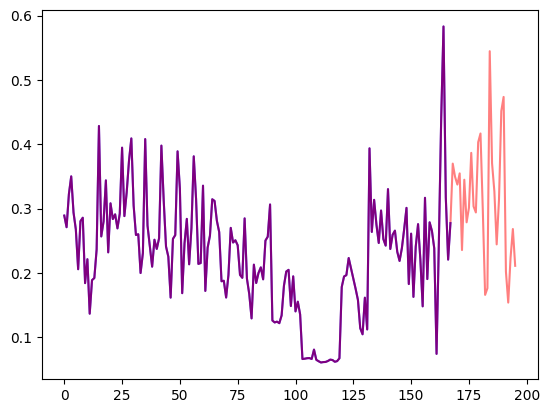

In [16]:
num_of_samples = 6 * prediction_length

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    validation_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

### 2.5 Splitting dataset

Splitting the dataset into training, validation, and test sets allows us to train the model, tune hyperparameters, and evaluate performance on unseen data.

In [17]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [18]:
# Converting the start field to pandas Period

from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [19]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [20]:
train_dataset[0]["start"]

Period('2006-12-16', 'D')

### 2.6 Create rolling windows

Rolling windows are used to create overlapping sequences for training and testing. This approach helps the model learn from multiple segments of the time series and improves its ability to forecast future values.

In [21]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [22]:
multi_variate_train_example = multi_variate_train_dataset[0]
multi_variate_test_example = multi_variate_test_dataset[0]
print("multi_variate_train_example['target'].shape =", multi_variate_train_example["target"].shape)
print("multi_variate_test_example['target'].shape =", multi_variate_test_example["target"].shape)

multi_variate_train_example['target'].shape = (7, 1386)
multi_variate_test_example['target'].shape = (7, 1442)


## 3. Modeling

In this section, we define and configure the Transformer-based model for time series forecasting. The model is set up to handle multivariate time series data and is tailored to the characteristics of the energy consumption dataset.

### 3.1 Model config
The model configuration specifies the architecture and hyperparameters of the Transformer, such as input size, prediction length, context length, and number of layers.

In [23]:
from src.model import get_informer_config
from transformers import InformerForPrediction

num_of_variates = len(train_dataset)
lags_sequence = [1, 2, 7, 14, 28, 56, 112, 224]
context_length = prediction_length * 6

config = get_informer_config(
    num_of_variates=num_of_variates,
    prediction_length=prediction_length,
    context_length=context_length,
    lags_sequence=lags_sequence,
    time_features=["day_of_week", "day_of_month", "day_of_year"]
)

model = InformerForPrediction(config)

In [24]:
# We will iterate over the individual time series of our dataset and add/remove fields or features
from src.transformer import create_train_dataloader, create_backtest_dataloader

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=64,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=16,
)


In [25]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())


past_time_features torch.Size([64, 392, 4]) torch.FloatTensor
past_values torch.Size([64, 392, 7]) torch.FloatTensor
past_observed_mask torch.Size([64, 392, 7]) torch.FloatTensor
future_time_features torch.Size([64, 28, 4]) torch.FloatTensor
future_values torch.Size([64, 28, 7]) torch.FloatTensor
future_observed_mask torch.Size([64, 28, 7]) torch.FloatTensor


### 3.3 Create model

The model is instantiated and prepared for training. This includes setting up the optimizer and loss function.

<!-- The model is now ready for training. We perform a forward pass to ensure the data pipeline and model are working as expected before starting the training loop. -->

In [26]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [27]:
print("Loss:", outputs.loss.item())

Loss: 3.6857528686523438


## 3.4 Training

The training process involves optimizing the model parameters using the training data. We monitor the training and validation loss to prevent overfitting and apply early stopping if the validation loss does not improve.

<!-- 
The training process is crucial for the model to learn from the data. We use the training data to adjust the model parameters, aiming to minimize the loss function. The loss function measures how well the model's predictions match the actual data. By optimizing the model parameters, we improve the model's performance.

To ensure that the model generalizes well to unseen data, we split the data into training and validation sets. The training set is used to train the model, while the validation set is used to evaluate its performance. We monitor the loss on both sets during training.

Overfitting occurs when the model learns the training data too well, including its noise and outliers. This results in poor performance on new, unseen data. To prevent overfitting, we use techniques such as early stopping.

Early stopping is a form of regularization used to avoid overfitting. It involves monitoring the validation loss during training and stopping the training process if the validation loss does not improve for a certain number of epochs. This way, we can ensure that the model maintains the ability to generalize to new data.
-->

In [28]:
from src.model import train_model
from accelerate import Accelerator

epochs = 20
loss_history = []
val_loss_history = []
best_val_loss = float('inf')
patience = 5
counter = 0

accelerator = Accelerator()
device = accelerator.device

model.to(device)

loss_history, val_loss_history = train_model(
    model,
    train_dataloader,
    test_dataloader,
    multi_variate_test_dataset,
    config,
    prediction_length,
    epochs=20,
    patience=5,
    num_batches_per_epoch=100
)

Epoch 1, Train Loss: -3.7426, Val MSE: 0.0196
Epoch 2, Train Loss: -5.8389, Val MSE: 0.0197
Epoch 3, Train Loss: -6.8067, Val MSE: 0.0192
Epoch 4, Train Loss: -7.2738, Val MSE: 0.0222
Epoch 5, Train Loss: -7.6954, Val MSE: 0.0211
Epoch 6, Train Loss: -8.0097, Val MSE: 0.0198
Epoch 7, Train Loss: -8.3478, Val MSE: 0.0202
Epoch 8, Train Loss: -8.8259, Val MSE: 0.0185
Epoch 9, Train Loss: -9.0976, Val MSE: 0.0189
Epoch 10, Train Loss: -9.3377, Val MSE: 0.0195
Epoch 11, Train Loss: -9.5144, Val MSE: 0.0181
Epoch 12, Train Loss: -9.6692, Val MSE: 0.0198
Epoch 13, Train Loss: -9.8958, Val MSE: 0.0203
Epoch 14, Train Loss: -10.1299, Val MSE: 0.0193
Epoch 15, Train Loss: -10.3194, Val MSE: 0.0200
Early stopping after 16 epochs


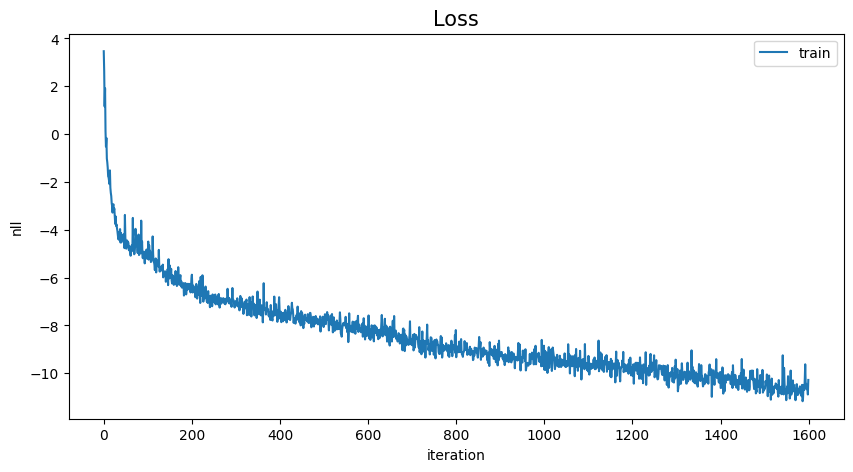

In [29]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

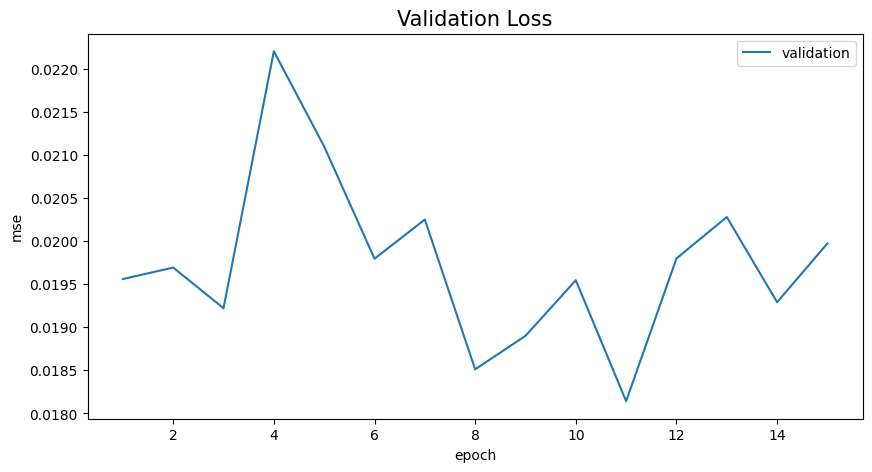

In [31]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label="validation")
plt.title("Validation Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

## 4. Evaluation

After training, we evaluate the model on the test set. We calculate performance metrics such as Mean Squared Error (MSE) and visualize the predictions against the actual values to assess the model's forecasting ability.

### Generating Predictions

We use the trained model to generate forecasts for the test set. The predictions are then compared to the actual values to evaluate model performance.

In [32]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts_)

In [33]:
from src.evaluation import compute_mean_mse

mse_values, mean_mse = compute_mean_mse(multi_variate_test_dataset, forecasts, prediction_length)
for i, mse in enumerate(mse_values):
    print(f"{tags[i]}: MSE = {mse:.4f}")
print(f"Mean MSE across all variables: {mean_mse:.4f}")

Global_active_power: MSE = 0.0099
Global_reactive_power: MSE = 0.0081
Voltage: MSE = 0.0188
Global_intensity: MSE = 0.0094
Sub_metering_1: MSE = 0.0254
Sub_metering_2: MSE = 0.0429
Sub_metering_3: MSE = 0.0249
Mean MSE across all variables: 0.0199


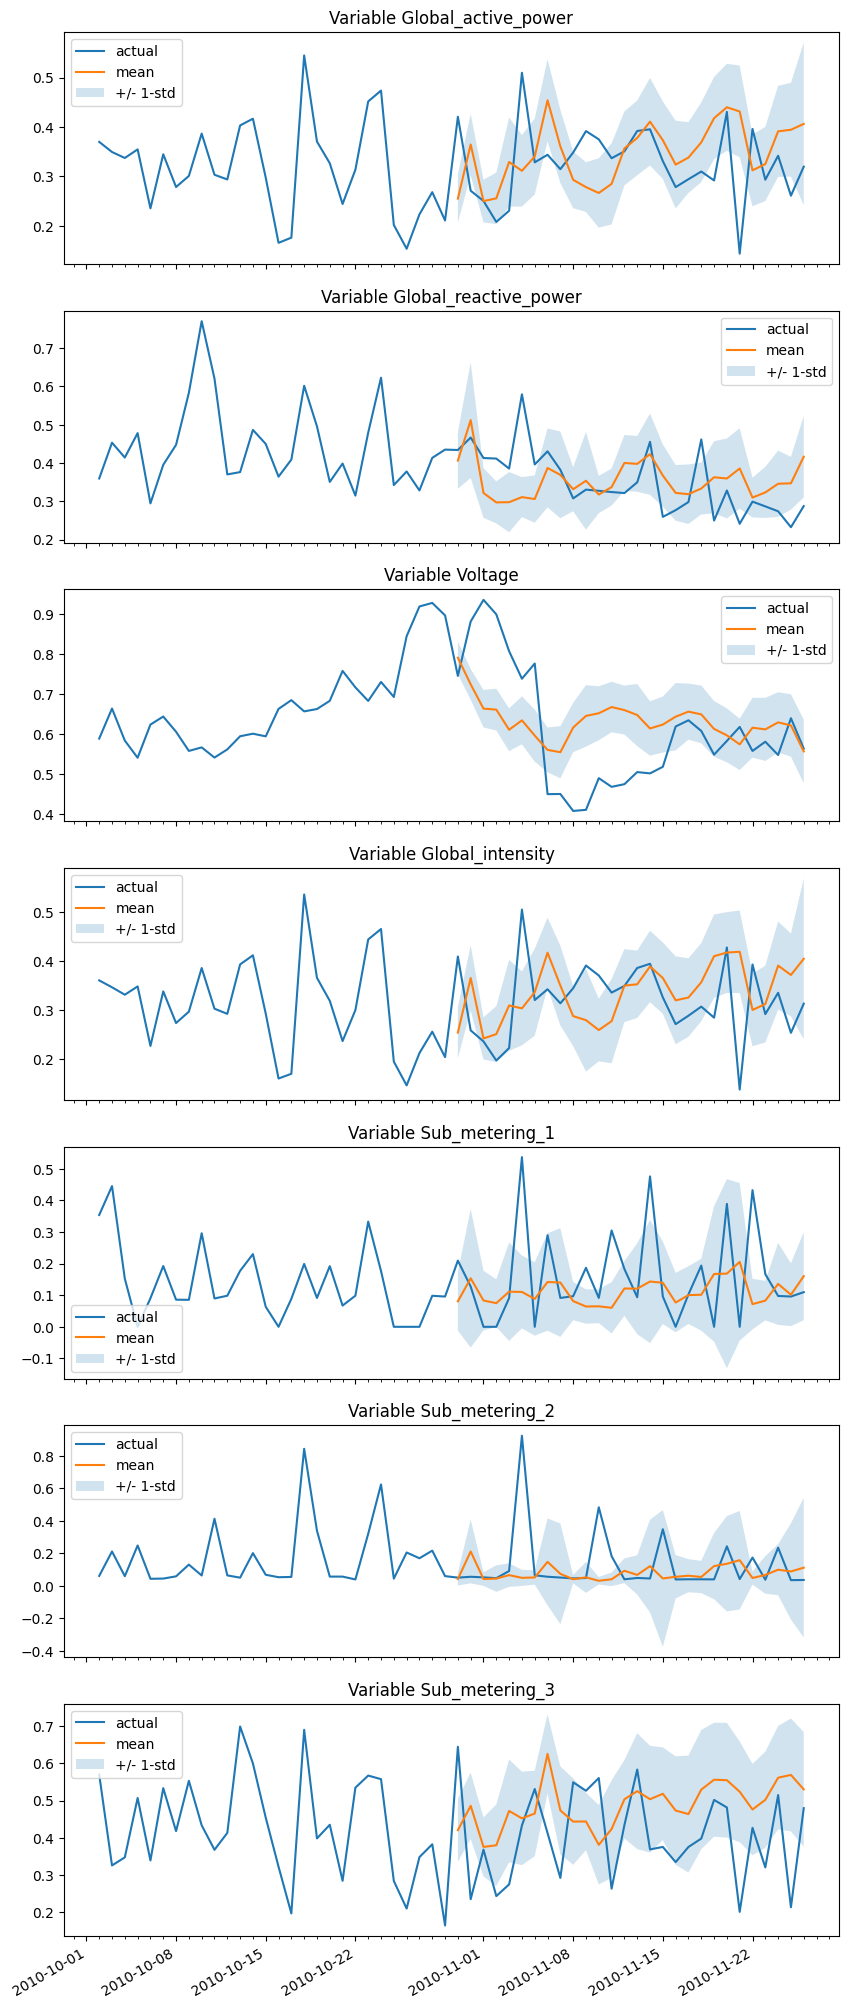

In [36]:
from src.evaluation import plot_forecasts
from gluonts.dataset.field_names import FieldName

plot_forecasts([0,1,2,3,4,5,6], tags, multi_variate_test_dataset, forecasts, prediction_length, FieldName)

## 5. Conclusion

The Informer-based Transformer model demonstrated strong performance in forecasting daily household energy consumption. The final prediction plots show that the model is able to closely follow the actual values for all variables, with the predicted means and confidence intervals generally capturing the true trends and fluctuations. The Mean Squared Error (MSE) values across all variables are low, indicating accurate predictions. Although the predictions for the submeterings could be better, the model generalizes well and provides reliable forecasts. This approach is effective for multivariate time series forecasting in energy consumption scenarios.